# Plotting Basic Flow Metrics on the Double Gyre
By Tanner Harms


In [1]:
# General imports that may be useful throughout:
import os, sys, copy
import numpy as np
from matplotlib import pyplot as plt

## Computing Geometric LCS
Great.  Now that we have visualized the flow, let's compute some LCS.  First, though, we should make a denser grid of particles. 

In [2]:
# Import the functions from the Flows folder
from Flows.Flows import Flow

# Initialize a flow object
function_name = "Gyre"
gyre = Flow()
gyre2 = Flow()

# Now, make a denser grid of particles
n_y = 25              # number of rows
dx = 1/n_y              # row spacing
buff = 0.0001
domain = np.array([[0 + buff, 2 - buff],[0 + buff, 1 - buff]])
x_vec = np.arange(domain[0,0],domain[0,1]+dx,dx)     # 50 columns
y_vec = np.arange(domain[1,0],domain[1,1]+dx,dx)     # 25 rows

# Then, make the mesh grid and flatten it to get a single vector of positions.  
mesh = np.meshgrid(x_vec, y_vec)
x = mesh[0].reshape(-1,1)
y = mesh[1].reshape(-1,1)
initial_conditions = np.append(x, y, axis=1)

# Next, we need to make a time vector
t0 = 0       # initial time
t1 = 15      # final time
dt = 0.25    # time increment <- # For standard FTLE we will only need the first and last time, but 
                                # it will be helpful when computing LAVD to have increments.
time_vector = np.arange(t0,t1+dt,dt)
time_vector2 = np.arange(t0,(t0-(t1- t0))-dt,-dt)
time_vector2 = np.arange(t1,t0-dt,-dt)

'''We now need to specify the flow that the Flow object will operate on.'''
parameters = {  # These are specified as defaults as well. 
    "A": 0.1,
    "epsilon":0.1,
    "omega":2*np.pi/10
}
gyre.predefined_function(function_name, initial_conditions, time_vector,
                         parameters=parameters, include_gradv=True)  # <- including gradv for LAVD
gyre2.predefined_function(function_name, initial_conditions, time_vector2,
                         parameters=parameters, include_gradv=True)

## Plotting Instantaneous Metrics
Here we will compute vorticity, instantaneous vorticity deviation, principal strain rate, and Q criterion

In [3]:
# import our custom colormaps
from Utils import colormaps as cms
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Set interpreter to latex
plt.rc('text', usetex=True)

# Plot the vorticity at a snapshot in time to demonstrate gradient function
snap_time = 0
vort = np.zeros_like(mesh[0])
eps = np.zeros_like(mesh[0])
Q = np.zeros_like(mesh[0])
for i, x in enumerate(x_vec):
    for j, y in enumerate(y_vec):
        gradv = gyre.gradv_function([x,y],snap_time)
        vort[j,i] = gradv[1,0] - gradv[0,1]
        W = 0.5 * (gradv.T - gradv)
        D = 0.5 * (gradv.T + gradv)
        eps[j,i] = np.max(np.linalg.eig(D)[0])
        Q[j,i] = 0.5 * (np.linalg.norm(W)**2 - np.linalg.norm(D)**2)

# IVD needs the mean vorticity subtracted.
IVD = np.abs(vort - np.mean(vort))        

In [4]:
plt.rcParams['font.family'] = 'serif'
# plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

# make the figure
fig, axs = plt.subplots(2,2,figsize=(10, 5))

p1 = axs[0,0].pcolormesh(mesh[0], mesh[1], vort, cmap="RdBu_r")
axs[0,0].axis('scaled')
divider = make_axes_locatable(axs[0,0])
cax1 = divider.append_axes("right", size="5%", pad=0.05)

p2 = axs[0,1].pcolormesh(mesh[0], mesh[1], IVD, cmap="gray2blue")
axs[0,1].axis('scaled')
divider = make_axes_locatable(axs[0,1])
cax2 = divider.append_axes("right", size="5%", pad=0.05)

p3 = axs[1,0].pcolormesh(mesh[0], mesh[1], eps, cmap="gray2red")
axs[1,0].axis('scaled')
divider = make_axes_locatable(axs[1,0])
cax3 = divider.append_axes("right", size="5%", pad=0.05)

red2gray2blue = cms.stitchColormaps(Q,"gray2red_r","gray2blue",0)
p4 = axs[1,1].pcolormesh(mesh[0], mesh[1], Q, cmap=red2gray2blue)
axs[1,1].axis('scaled')
divider = make_axes_locatable(axs[1,1])
cax4 = divider.append_axes("right", size="5%", pad=0.05)

# colorbars
fig.colorbar(p1, cax=cax1)
fig.colorbar(p2, cax=cax2)
fig.colorbar(p3, cax=cax3)
fig.colorbar(p4, cax=cax4)

# clearing axes
axs[0,0].set_xticklabels([])
axs[0,1].set_xticklabels([])
axs[0,1].set_yticklabels([])
axs[1,1].set_yticklabels([])

# add labels
letters = ["(a)", '(b)', '(c)', '(d)']
for i, ax in enumerate(axs.flat):
    ax.text(0.025, 0.95, letters[i], horizontalalignment='left', verticalalignment='top',
            transform=ax.transAxes, fontsize=14, weight="bold")


fig.patch.set_alpha(0)
fig.tight_layout()

# fig.savefig('instantaneous_mets.png', transparent=True, dpi=450)

### Finite-Time Lyapunov Exponent (FTLE) and Lagrangian-Averaged Voriticty Deviation (LAVD)
We shall now compute the finite-time Lyapunov exponents.  These were the original LCS metric (See Haller and Yuan 2000), and indicate the rate of stretching for a linear deformation from time 0 to time 1.  Here we will to calculate them the traditional way using numerical gradients.  Additionally we will compute the LAVD for this flow, which indicates the amount of rotation that a fluid element undergoes during a time interval.  Specifically, it is the Lagrangian (that is, along a particle) average of the magnitude of the vorticity over a time domain.  The result represents twice the intrinsic rotation angle, which represents the angle of rotation a particle experiences with respect to its own frame of reference.  

In [ ]:
import GeometricLCS.Geometric as geom

# First, integrate the trajectories.
print("Integrating Trajectories...")
gyre.integrate_trajectories()
gyre2.integrate_trajectories()


Integrating Trajectories...


In [ ]:

# Computing the jacobian at each mesh position
print("Computing Jacobians...")
J_array = geom.computeJacobian(gyre.states, mesh)
J_array2 = geom.computeJacobian(gyre2.states, mesh)

# J_array stores a d-by-d array at each particle mesh location.
print(np.shape(J_array))

# Computing the FTLE field.
print("Computing FTLE...")
forward_ftle_field = geom.computeFTLE(J_array, t1-t0)
backward_ftle_field = geom.computeFTLE(J_array2, t1-t0)

# Computing the LAVD field.
print("Computing LAVD...")
ivd_array = geom.computeIVD(gyre.states, gyre.time_vector, gyre.gradv_function)
lavd_array = geom.computeLAVD(ivd_array, gyre.time_vector, len(gyre.time_vector))
dra_array = geom.computeDRA(ivd_array, gyre.time_vector, len(gyre.time_vector))
lavd_field = lavd_array[:,0].reshape(tuple(list(np.shape(mesh)[1:]))) / (4*np.pi)
dra_field = dra_array[:,0].reshape(tuple(list(np.shape(mesh)[1:]))) / (4*np.pi)

# Computing FTQ field
print("Computing FTQ...")
D_array, W_array = geom.computeDandW(gyre.states, gyre.time_vector, gyre.gradv_function)
ftq_array = geom.computeFTQ(D_array, W_array, gyre.time_vector, len(gyre.time_vector))
tism_array = geom.computeTISM(D_array, gyre.time_vector, len(gyre.time_vector))
ftq_field = ftq_array[:,0].reshape(tuple(list(np.shape(mesh)[1:])))
tism_field = tism_array[:,0].reshape(tuple(list(np.shape(mesh)[1:])))

ivd_array = geom.computeIVD(gyre2.states, gyre2.time_vector, gyre2.gradv_function)
back_lavd_array = geom.computeLAVD(ivd_array, gyre2.time_vector, len(gyre2.time_vector))
back_lavd_field = back_lavd_array[:,0].reshape(tuple(list(np.shape(mesh)[1:]))) / (4*np.pi)


Computing Jacobians...
(26, 51, 2, 2)
Computing FTLE...
Computing LAVD...
Computing FTQ...


NameError: name 'ftq_array' is not defined

C:\Users\harms\AppData\Local\Temp\ipykernel_34980\1270938908.py:57: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


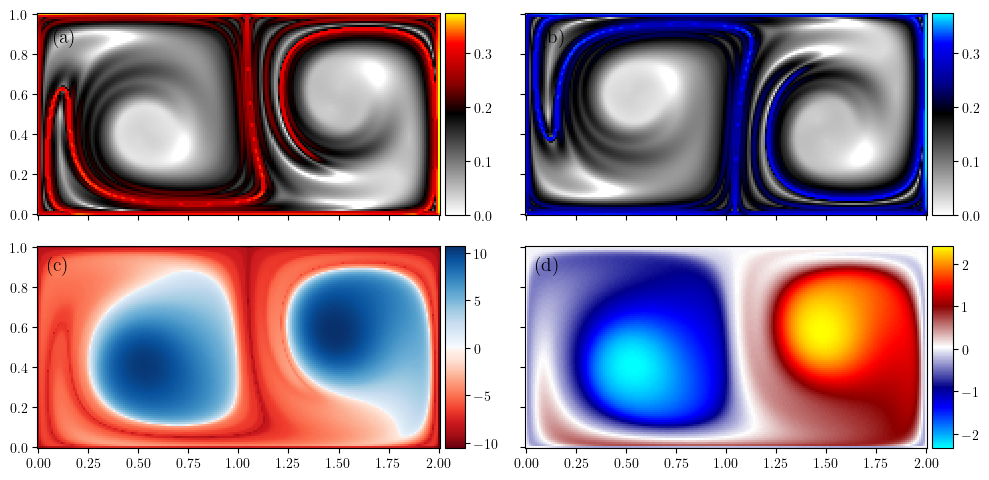

In [ ]:
# Creating a figure
fig, axs = plt.subplots(2,2,figsize=(10, 5))

p1 = axs[0,0].pcolormesh(mesh[0], mesh[1], forward_ftle_field, cmap="gray2hot", vmin=0)
axs[0,0].axis('scaled')
divider = make_axes_locatable(axs[0,0])
cax1 = divider.append_axes("right", size="5%", pad=0.05)

p2 = axs[0,1].pcolormesh(mesh[0], mesh[1], backward_ftle_field, cmap="gray2lime", vmin=0)
axs[0,1].axis('scaled')
divider = make_axes_locatable(axs[0,1])
cax2 = divider.append_axes("right", size="5%", pad=0.05)

p3 = axs[1,0].pcolormesh(mesh[0], mesh[1], lavd_field, cmap="gray2cool")
axs[1,0].axis('scaled')
divider = make_axes_locatable(axs[1,0])
cax3 = divider.append_axes("right", size="5%", pad=0.05)

p4 = axs[1,1].pcolormesh(mesh[0], mesh[1], dra_field, cmap="highContrast_b2r_white")
axs[1,1].axis('scaled')
divider = make_axes_locatable(axs[1,1])
cax4 = divider.append_axes("right", size="5%", pad=0.05)

# colorbars
fig.colorbar(p1, cax=cax1)
fig.colorbar(p2, cax=cax2)
fig.colorbar(p3, cax=cax3)
fig.colorbar(p4, cax=cax4)

# clearing axes
axs[0,0].set_xticklabels([])
axs[0,1].set_xticklabels([])
axs[0,1].set_yticklabels([])
axs[1,1].set_yticklabels([])

# add labels
letters = ["(a)", '(b)', '(c)', '(d)']
for i, ax in enumerate(axs.flat):
    if i < 2:
        ax.text(0.04, 0.925, letters[i], horizontalalignment='left', verticalalignment='top',
            transform=ax.transAxes, fontsize=14, weight="bold")
    else:
        ax.text(0.025, 0.95, letters[i], horizontalalignment='left', verticalalignment='top',
                transform=ax.transAxes, fontsize=14, weight="bold")

fig.patch.set_alpha(0)
fig.tight_layout()

# fig.savefig('finite_time_mets.png', transparent=True, dpi=450)

fig.tight_layout()
fig.show()


C:\Users\harms\AppData\Local\Temp\ipykernel_34980\715976083.py:38: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


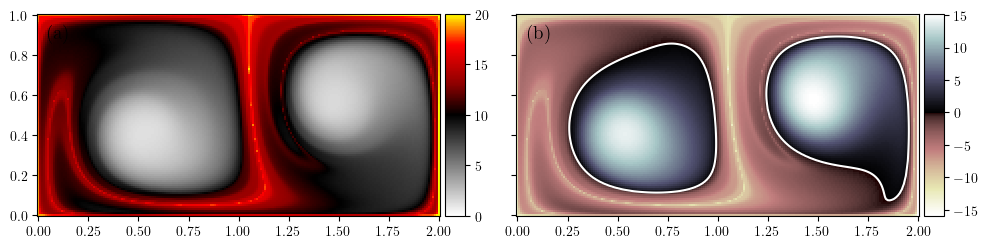

In [ ]:
# Creating a figure
fig, axs = plt.subplots(1,2,figsize=(10, 2.5))

# Trajectory-Integrated Strain Magnitude
p1 = axs[0].pcolormesh(mesh[0], mesh[1], tism_field, cmap="gray2hot", vmin=0, vmax=20)
axs[0].axis('scaled')
divider = make_axes_locatable(axs[0])
cax1 = divider.append_axes("right", size="5%", pad=0.05)

# Finite-time Q-criterion
red2gray2blue = cms.stitchColormaps(ftq_field,"pink_r","bone", stitch_at=0)
p2 = axs[1].pcolormesh(mesh[0], mesh[1], ftq_field, cmap=red2gray2blue)#cmap="highContrast_b2r_white")
c1 = axs[1].contour(mesh[0], mesh[1], ftq_field, levels=[0], colors='white', linewidths=1.5)
axs[1].axis('scaled')
divider = make_axes_locatable(axs[1])
cax2 = divider.append_axes("right", size="5%", pad=0.05)

# colorbars
fig.colorbar(p1, cax=cax1)
fig.colorbar(p2, cax=cax2)

# clearing axes
# axs[0].set_xticklabels([])
axs[1].set_yticklabels([])

# add labels
letters = ["(a)", '(b)']
for i, ax in enumerate(axs.flat):
    ax.text(0.025, 0.95, letters[i], horizontalalignment='left', verticalalignment='top',
            transform=ax.transAxes, fontsize=14, weight="bold")

fig.patch.set_alpha(0)
fig.tight_layout()

# fig.savefig('finite_time_mets.png', transparent=True, dpi=450)

fig.tight_layout()
fig.show()


In [ ]:
from skimage.feature import peak_local_max

# Apply argrelextrema to data to find all peak indices
forward_indices = peak_local_max(lavd_field, min_distance=1)
backward_indices = peak_local_max(back_lavd_field, min_distance=1)

# Print the coordinates of the peaks
for i in range(len(forward_indices[0])):
    print(f"Peak found at (x={forward_indices[0][i]}, y={forward_indices[1][i]})")
    
# Print the coordinates of the peaks
for i in range(len(backward_indices[0])):
    print(f"Peak found at (x={backward_indices[0][i]}, y={backward_indices[1][i]})")

    



NameError: name 'back_lavd_field' is not defined